### ДЗ №11. Transformers

Очень популярная статеечка http://jalammar.github.io/illustrated-transformer/
Просто по какой-то причине читать методичку (даже на русском языке) очень трудно. Даже код не всегда спасает. Такое чувство что это автоматический перевод (вот ведь ирония) какой-то оригинальной работы...

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow_datasets as tfds

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)

In [5]:
train_examples, val_examples = examples['train'], examples['validation']

In [6]:
i = iter(train_examples)

In [7]:
example = i.next()

In [8]:
tf.print(example[0])

к : успех , перемены возможны только с оружием в руках .


In [9]:
tf.print(example[1])

c : success , the change is only coming through the barrel of the gun .


In [10]:
print(tf.get_static_value(example[0]).decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .


In [11]:
# Сабворд токенизатор
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for ru, en in train_examples), target_vocab_size=2**13)

tokenizer_ru = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (ru.numpy() for ru, en in train_examples), target_vocab_size=2**13)

In [12]:
tokenized_string = tokenizer_en.encode('This is just a test')
tokenized_string

[8073, 139, 13, 54, 7, 2298]

In [13]:
tokenizer_en.decode(tokenized_string)

'This is just a test'

In [14]:
for token in tokenized_string:
    print(f'{token=} ===> "{tokenizer_en.decode([token])}"')

token=8073 ===> "T"
token=139 ===> "his "
token=13 ===> "is "
token=54 ===> "just "
token=7 ===> "a "
token=2298 ===> "test"


In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
# Функция кодирования (с добавлением метки начала и конца)

In [17]:
def encode(ru, en):
    ru = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(
      ru.numpy()) + [tokenizer_ru.vocab_size+1]

    en = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      en.numpy()) + [tokenizer_en.vocab_size+1]

    return ru, en

In [18]:
def tf_encode(ru, en):
    result_ru, result_en = tf.py_function(encode, [ru, en], [tf.int64, tf.int64])
    result_ru.set_shape([None])
    result_en.set_shape([None])

    return result_ru, result_en

In [19]:
MAX_LENGTH = 40

In [20]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [21]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [22]:
ru_batch, en_batch = next(iter(val_dataset))
ru_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

In [23]:
ru_batch[0]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8179,   57,   86,   54,  578,   84, 4550, 1003, 5905, 6326, 1197,
          2, 8180,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [24]:
# Positional encoder - готовим матрицу векторов (для всех позиций в предложении не более длины max_len)
# Потом будем их (соответствующий позиции вектор) добавлять к эмбеддингу каждого слова, 
# как кодированную позицию слова в предложении

$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $

$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $

In [25]:
np.arange(10)[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [26]:
(np.arange(10)[np.newaxis, :]//2) * 2

array([[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]])

In [27]:
1 / np.power(10000, (2 * (np.arange(50)[np.newaxis, :]//2)) / np.float32(512))

array([[1.        , 1.        , 0.96466162, 0.96466162, 0.93057204,
        0.93057204, 0.89768713, 0.89768713, 0.86596432, 0.86596432,
        0.83536255, 0.83536255, 0.80584219, 0.80584219, 0.77736503,
        0.77736503, 0.74989421, 0.74989421, 0.72339416, 0.72339416,
        0.69783058, 0.69783058, 0.67317038, 0.67317038, 0.64938163,
        0.64938163, 0.62643354, 0.62643354, 0.60429639, 0.60429639,
        0.58294153, 0.58294153, 0.56234133, 0.56234133, 0.54246909,
        0.54246909, 0.52329911, 0.52329911, 0.50480657, 0.50480657,
        0.48696753, 0.48696753, 0.46975888, 0.46975888, 0.45315836,
        0.45315836, 0.43714448, 0.43714448, 0.4216965 , 0.4216965 ]])

In [28]:
# То, от чего берется синус (для четных элементов) и косинус для нечетных
rates = (1 / np.power(10000, (2 * (np.arange(5)[np.newaxis, :]//2))\
                      / np.float32(512))) * np.arange(5)[:, np.newaxis]
rates

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.96466162, 0.96466162, 0.93057204],
       [2.        , 2.        , 1.92932324, 1.92932324, 1.86114408],
       [3.        , 3.        , 2.89398486, 2.89398486, 2.79171612],
       [4.        , 4.        , 3.85864648, 3.85864648, 3.72228816]])

In [29]:
2 * (np.arange(10)[np.newaxis, :]//2)

array([[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]])

In [30]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [31]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [32]:
positional_encoding(5, 512)

<tf.Tensor: shape=(1, 5, 512), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
          1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
        [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
          1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
        [ 1.4112000e-01, -9.8999250e-01,  2.4508542e-01, ...,
          9.9999994e-01,  3.1098988e-04,  9.9999994e-01],
        [-7.5680250e-01, -6.5364361e-01, -6.5716684e-01, ...,
          9.9999988e-01,  4.1465316e-04,  9.9999994e-01]]], dtype=float32)>

In [33]:
# Функция маскирующая паддинговые нули... не супер понятно для чего там эти два доп. измерения
# Написано для логитов внимания - вопрос - почему два....
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [34]:
# Маска закрывающая еще не предсказанную часть фразы. Чтобы самовнимание ее не использовало
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [35]:
# Scaled dot product attention
# Функция вычисления весов самовнимания. В нее подаются по три вектора Q, K, V производные из эмбеддингов слов.
# Для каждого слова берется Q и скалярно перемножается с K векторами всех слов - полученные веса скейлятся 
# на корень из длины вектора, от них берется софтмакс и на них множатся V вектора. 
# Все соскейленные V вектора суммируются в итоговый вектор self attention (output)

def scaled_dot_product_attention(q, k, v, mask=None):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # Непонятно, почему так? Зачем отнимать огромное значение, почему не умножить на что нибудь маленькое

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [36]:
q = tf.constant([[0.0, 1.0, 2.0, 3.0]])
k = tf.constant([[1.0, 0.0, 1.0, 0.0]])
v = tf.constant([[5.0, 5.0, 5.0, 5.0]])

In [37]:
tf.matmul(q, k, transpose_b=True)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

In [38]:
scaled_dot_product_attention(q, k, v)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5., 5., 5., 5.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [39]:
mask = tf.constant([[1]], dtype=tf.float32)

In [40]:
scaled_dot_product_attention(q, k, v, mask)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5., 5., 5., 5.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [41]:
q = tf.constant([[0.0, 1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 5.0]])
k = tf.constant([[1.0, 0.0, 1.0, 0.0], [2.0, 1.0, 0.0, 0.0]])
v = tf.constant([[5.0, 5.0, 5.0, 5.0], [3.0, 3.0, 35.0, 3.0]])
scaled_dot_product_attention(q, k, v)

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 4.244919,  4.244919, 16.32622 ,  4.244919],
        [ 4.      ,  4.      , 20.      ,  4.      ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.62245935, 0.37754068],
        [0.5       , 0.5       ]], dtype=float32)>)

In [42]:
# Многоголовость внимания
# Слоев внимания несколько. Для каждого слоя внимания мы прогоняем эмбеддинги через три dense слоя wq, wk, wv
# Таким образом получая Q K V вектора, которые разбираем на части с помощью reshape (сколько голов внимания - столько частей)
# Для всех вычисляется самовнимание и мы собираем матрицы векторов V из каждого "внимания" и конкатенейтим их (также через reshape). 
# И прогоняем через выходной FC слой. 

In [43]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [44]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [45]:
# Полносвязная сеточка (будет использоваться в конце енкодера)

In [46]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [47]:
# Энкодер в трансформере состоит из нескольких повторяющихся слоёв. Вот один слой энкодера
# В нем Multi-Head-Attention блок, выходная полносвязная сеть, и блоки нормализации и дропаут..
# Сначала данные попадают в MHA, затем дропаут, затем нормалайз, затем в полносвязную сеть и снова дропаут и нормалайз
# Кроме того есть два скип-соединения, один обходит MHA с дропаутом, 
# второй полносвязную сеть с дропаутом, чтобы при большой глубине не затухали градиенты

In [48]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [49]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [50]:
# Собственно сам энкодер
# Берет исходные фразы, делает для них эмбеддинги, скейлит их на корень из размерности эмбеддинга, добавляет позишн
# И прогоняет их через какое-то количество энкодер-слоев (рассмотренных выше)

In [51]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

In [52]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [53]:
# Декодер. Так-же как и энкодер состоит из повторяющихся слоёв. 
# Каждый слой берет входные данные (эмбеддинги фразы или то, что пришло из предыдущего слоя декодера)
# Вычисляет много-слойное само-внимание (с ограничением по маске). Маска в данном случае не дает вниманию
# Вычислять скор с токенами которые находятся правее предсказываемого в данный момент. (поскольку декодер 
# генерирует результат токен за токеном - маска сначала закрывает все токены, потом постепенно сдвигаясь вправо
# открывает ту часть которая уже была обработана)
# Далее следует дропаут и слой нормализации со скип-соединением снизу.
# После этого вычисляется скор еще одного самовнимания, на этот раз в нем используются Q и K вектора из Энкодера.
# А V вектор используется от первого внимания (после дропаута и нормализации)
# Дальше снова дропаут и нормалайз со скипом. 
# Далее полносвязная сеть и еще один проход дропаут и нормалайз. 
# И результат (V вектора, и веса первого и второго внимания) выдаются наружу для передачи в следующий слой декодера

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [55]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [56]:
# Собственно сам Декодер
# Все уже было расписано выше в основном.. Берем входные данные, эмбеддим их, скейлим корнем из глубины,
# Добавляем позишн энкодинг, дальше дропаут и прогоняем через пачку слоев декодера (зачем-то сохраняем веса внимания)

In [57]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [58]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [59]:
# Весь Трансформер.. Энкодер, декодер и финальный полносвязный слой

In [60]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [61]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [62]:
# Гиперпараметры... 
# В оригинальном трансформере эмбеддинг 512, слоев энкодере и декодере по 6, размерность полносвязных слоев 2048

In [63]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8

input_vocab_size = tokenizer_ru.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

Оптимайзер с variable learning rate. Формула из пэйпера [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [65]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

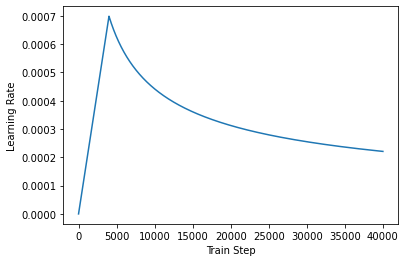

In [66]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [67]:
# Лосс функция. И метрика. Поскольку секвенции имеют паддинг - нужно исключать его из вычислений

In [68]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [69]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [70]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [71]:
# Попробуем по-тренировать

In [72]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [73]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [74]:
checkpoint_path = "./checkpoints/train_full"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [75]:
# Процесс тренировки - в энкодер подаются исходные фразы, 
# В декодер подаются таргетный фразы. Таргет подается в двух видах, снизу в исходном, сверху в сдвинутом на -1, 
# Поскольку предсказание энкодера (и процесс тренировки тоже) происходит в пошаговом режиме (предсказывается
# по одному токену за шаг, а следующее предсказание строится на результатах предыдущего)
# Сдвиг таргета делается чтобы таргетом для текущего слова было следующее - как при тренировке генерации текста...
# Используется forced supervised learning, то-есть независимо от того, что предсказал на предыдущем шаге декодер
# Следующий таргет все равно выдается по плану. (не отступает от эталонной таргетной фразы)
# Чтобы самовнимание не учитывало часть как-бы "еще не предсказанной" фразу - используется look-ahead-mask
# Это по-сути очевидно только на этапе тренировки, поскольку на инференсе - эта часть фразы и так неизвестна

In [76]:
EPOCHS = 10

In [77]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [78]:
history = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    history.append(train_loss.result())
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0171 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7330 Accuracy 0.0362
Epoch 1 Batch 100 Loss 8.4700 Accuracy 0.0449
Epoch 1 Batch 150 Loss 8.2470 Accuracy 0.0491
Epoch 1 Batch 200 Loss 7.9909 Accuracy 0.0603
Epoch 1 Batch 250 Loss 7.7247 Accuracy 0.0730
Epoch 1 Batch 300 Loss 7.4934 Accuracy 0.0822
Epoch 1 Batch 350 Loss 7.3075 Accuracy 0.0895
Epoch 1 Batch 400 Loss 7.1563 Accuracy 0.0972
Epoch 1 Batch 450 Loss 7.0201 Accuracy 0.1063
Epoch 1 Batch 500 Loss 6.8926 Accuracy 0.1156
Epoch 1 Batch 550 Loss 6.7675 Accuracy 0.1253
Epoch 1 Batch 600 Loss 6.6533 Accuracy 0.1341
Epoch 1 Batch 650 Loss 6.5475 Accuracy 0.1426
Epoch 1 Batch 700 Loss 6.4493 Accuracy 0.1504
Epoch 1 Batch 750 Loss 6.3592 Accuracy 0.1575
Epoch 1 Batch 800 Loss 6.2752 Accuracy 0.1643
Epoch 1 Batch 850 Loss 6.1963 Accuracy 0.1707
Epoch 1 Batch 900 Loss 6.1258 Accuracy 0.1763
Epoch 1 Batch 950 Loss 6.0611 Accuracy 0.1814
Epoch 1 Batch 1000 Loss 5.9995 Accuracy 0.1863
Epoch 1 Batch 1050 Loss 5.9430 Accur

Epoch 4 Batch 600 Loss 3.7957 Accuracy 0.3492
Epoch 4 Batch 650 Loss 3.7934 Accuracy 0.3494
Epoch 4 Batch 700 Loss 3.7920 Accuracy 0.3494
Epoch 4 Batch 750 Loss 3.7904 Accuracy 0.3495
Epoch 4 Batch 800 Loss 3.7891 Accuracy 0.3495
Epoch 4 Batch 850 Loss 3.7897 Accuracy 0.3494
Epoch 4 Batch 900 Loss 3.7889 Accuracy 0.3494
Epoch 4 Batch 950 Loss 3.7873 Accuracy 0.3495
Epoch 4 Batch 1000 Loss 3.7855 Accuracy 0.3497
Epoch 4 Batch 1050 Loss 3.7837 Accuracy 0.3499
Epoch 4 Batch 1100 Loss 3.7822 Accuracy 0.3500
Epoch 4 Batch 1150 Loss 3.7809 Accuracy 0.3501
Epoch 4 Batch 1200 Loss 3.7800 Accuracy 0.3502
Epoch 4 Batch 1250 Loss 3.7784 Accuracy 0.3504
Epoch 4 Batch 1300 Loss 3.7774 Accuracy 0.3504
Epoch 4 Batch 1350 Loss 3.7762 Accuracy 0.3505
Epoch 4 Batch 1400 Loss 3.7744 Accuracy 0.3507
Epoch 4 Batch 1450 Loss 3.7742 Accuracy 0.3508
Epoch 4 Batch 1500 Loss 3.7731 Accuracy 0.3508
Epoch 4 Batch 1550 Loss 3.7710 Accuracy 0.3511
Epoch 4 Batch 1600 Loss 3.7695 Accuracy 0.3512
Epoch 4 Batch 1650 Lo

Epoch 7 Batch 1150 Loss 3.4488 Accuracy 0.3788
Epoch 7 Batch 1200 Loss 3.4486 Accuracy 0.3787
Epoch 7 Batch 1250 Loss 3.4476 Accuracy 0.3788
Epoch 7 Batch 1300 Loss 3.4469 Accuracy 0.3790
Epoch 7 Batch 1350 Loss 3.4455 Accuracy 0.3790
Epoch 7 Batch 1400 Loss 3.4453 Accuracy 0.3790
Epoch 7 Batch 1450 Loss 3.4452 Accuracy 0.3791
Epoch 7 Batch 1500 Loss 3.4441 Accuracy 0.3793
Epoch 7 Batch 1550 Loss 3.4434 Accuracy 0.3794
Epoch 7 Batch 1600 Loss 3.4439 Accuracy 0.3793
Epoch 7 Batch 1650 Loss 3.4428 Accuracy 0.3794
Epoch 7 Batch 1700 Loss 3.4427 Accuracy 0.3795
Epoch 7 Batch 1750 Loss 3.4420 Accuracy 0.3795
Epoch 7 Batch 1800 Loss 3.4414 Accuracy 0.3796
Epoch 7 Batch 1850 Loss 3.4409 Accuracy 0.3797
Epoch 7 Batch 1900 Loss 3.4405 Accuracy 0.3798
Epoch 7 Batch 1950 Loss 3.4399 Accuracy 0.3798
Epoch 7 Batch 2000 Loss 3.4399 Accuracy 0.3798
Epoch 7 Batch 2050 Loss 3.4391 Accuracy 0.3799
Epoch 7 Batch 2100 Loss 3.4388 Accuracy 0.3800
Epoch 7 Batch 2150 Loss 3.4393 Accuracy 0.3799
Epoch 7 Batch

Epoch 10 Batch 1700 Loss 3.2470 Accuracy 0.3973
Epoch 10 Batch 1750 Loss 3.2465 Accuracy 0.3974
Epoch 10 Batch 1800 Loss 3.2457 Accuracy 0.3975
Epoch 10 Batch 1850 Loss 3.2456 Accuracy 0.3975
Epoch 10 Batch 1900 Loss 3.2448 Accuracy 0.3976
Epoch 10 Batch 1950 Loss 3.2449 Accuracy 0.3977
Epoch 10 Batch 2000 Loss 3.2447 Accuracy 0.3977
Epoch 10 Batch 2050 Loss 3.2443 Accuracy 0.3976
Epoch 10 Batch 2100 Loss 3.2440 Accuracy 0.3977
Epoch 10 Batch 2150 Loss 3.2439 Accuracy 0.3976
Epoch 10 Batch 2200 Loss 3.2440 Accuracy 0.3976
Epoch 10 Batch 2250 Loss 3.2433 Accuracy 0.3977
Epoch 10 Batch 2300 Loss 3.2429 Accuracy 0.3977
Epoch 10 Batch 2350 Loss 3.2431 Accuracy 0.3976
Epoch 10 Batch 2400 Loss 3.2431 Accuracy 0.3977
Epoch 10 Batch 2450 Loss 3.2424 Accuracy 0.3977
Epoch 10 Batch 2500 Loss 3.2422 Accuracy 0.3977
Epoch 10 Batch 2550 Loss 3.2426 Accuracy 0.3976
Epoch 10 Batch 2600 Loss 3.2425 Accuracy 0.3977
Saving checkpoint for epoch 10 at ./checkpoints/train_full/ckpt-2
Epoch 10 Loss 3.2422 A

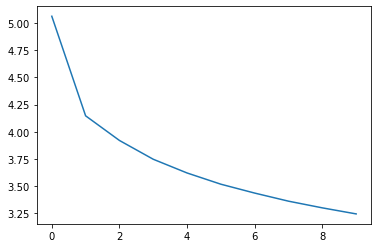

In [79]:
plt.plot(history)
plt.show()

In [80]:
EPOCHS = 40
history = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    history.append(train_loss.result())
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.1811 Accuracy 0.4075
Epoch 1 Batch 50 Loss 3.1700 Accuracy 0.4044
Epoch 1 Batch 100 Loss 3.1891 Accuracy 0.4024
Epoch 1 Batch 150 Loss 3.1902 Accuracy 0.4020
Epoch 1 Batch 200 Loss 3.2003 Accuracy 0.4002
Epoch 1 Batch 250 Loss 3.2005 Accuracy 0.3999
Epoch 1 Batch 300 Loss 3.2023 Accuracy 0.4000
Epoch 1 Batch 350 Loss 3.2025 Accuracy 0.4004
Epoch 1 Batch 400 Loss 3.1986 Accuracy 0.4011
Epoch 1 Batch 450 Loss 3.2013 Accuracy 0.4008
Epoch 1 Batch 500 Loss 3.2007 Accuracy 0.4009
Epoch 1 Batch 550 Loss 3.2010 Accuracy 0.4010
Epoch 1 Batch 600 Loss 3.2008 Accuracy 0.4011
Epoch 1 Batch 650 Loss 3.2006 Accuracy 0.4012
Epoch 1 Batch 700 Loss 3.1993 Accuracy 0.4014
Epoch 1 Batch 750 Loss 3.1986 Accuracy 0.4012
Epoch 1 Batch 800 Loss 3.1979 Accuracy 0.4014
Epoch 1 Batch 850 Loss 3.1978 Accuracy 0.4016
Epoch 1 Batch 900 Loss 3.1987 Accuracy 0.4015
Epoch 1 Batch 950 Loss 3.1992 Accuracy 0.4014
Epoch 1 Batch 1000 Loss 3.1975 Accuracy 0.4016
Epoch 1 Batch 1050 Loss 3.1968 Accur

Epoch 4 Batch 600 Loss 3.0701 Accuracy 0.4129
Epoch 4 Batch 650 Loss 3.0714 Accuracy 0.4128
Epoch 4 Batch 700 Loss 3.0712 Accuracy 0.4127
Epoch 4 Batch 750 Loss 3.0724 Accuracy 0.4124
Epoch 4 Batch 800 Loss 3.0726 Accuracy 0.4126
Epoch 4 Batch 850 Loss 3.0715 Accuracy 0.4128
Epoch 4 Batch 900 Loss 3.0716 Accuracy 0.4128
Epoch 4 Batch 950 Loss 3.0712 Accuracy 0.4130
Epoch 4 Batch 1000 Loss 3.0711 Accuracy 0.4131
Epoch 4 Batch 1050 Loss 3.0711 Accuracy 0.4131
Epoch 4 Batch 1100 Loss 3.0704 Accuracy 0.4131
Epoch 4 Batch 1150 Loss 3.0702 Accuracy 0.4132
Epoch 4 Batch 1200 Loss 3.0701 Accuracy 0.4132
Epoch 4 Batch 1250 Loss 3.0701 Accuracy 0.4133
Epoch 4 Batch 1300 Loss 3.0691 Accuracy 0.4134
Epoch 4 Batch 1350 Loss 3.0700 Accuracy 0.4132
Epoch 4 Batch 1400 Loss 3.0698 Accuracy 0.4133
Epoch 4 Batch 1450 Loss 3.0701 Accuracy 0.4133
Epoch 4 Batch 1500 Loss 3.0692 Accuracy 0.4134
Epoch 4 Batch 1550 Loss 3.0686 Accuracy 0.4135
Epoch 4 Batch 1600 Loss 3.0686 Accuracy 0.4135
Epoch 4 Batch 1650 Lo

Epoch 7 Batch 1150 Loss 2.9723 Accuracy 0.4227
Epoch 7 Batch 1200 Loss 2.9738 Accuracy 0.4224
Epoch 7 Batch 1250 Loss 2.9738 Accuracy 0.4224
Epoch 7 Batch 1300 Loss 2.9737 Accuracy 0.4225
Epoch 7 Batch 1350 Loss 2.9736 Accuracy 0.4225
Epoch 7 Batch 1400 Loss 2.9739 Accuracy 0.4225
Epoch 7 Batch 1450 Loss 2.9743 Accuracy 0.4225
Epoch 7 Batch 1500 Loss 2.9747 Accuracy 0.4225
Epoch 7 Batch 1550 Loss 2.9753 Accuracy 0.4224
Epoch 7 Batch 1600 Loss 2.9746 Accuracy 0.4225
Epoch 7 Batch 1650 Loss 2.9745 Accuracy 0.4226
Epoch 7 Batch 1700 Loss 2.9741 Accuracy 0.4227
Epoch 7 Batch 1750 Loss 2.9738 Accuracy 0.4227
Epoch 7 Batch 1800 Loss 2.9742 Accuracy 0.4227
Epoch 7 Batch 1850 Loss 2.9745 Accuracy 0.4227
Epoch 7 Batch 1900 Loss 2.9746 Accuracy 0.4227
Epoch 7 Batch 1950 Loss 2.9742 Accuracy 0.4227
Epoch 7 Batch 2000 Loss 2.9743 Accuracy 0.4227
Epoch 7 Batch 2050 Loss 2.9740 Accuracy 0.4227
Epoch 7 Batch 2100 Loss 2.9735 Accuracy 0.4227
Epoch 7 Batch 2150 Loss 2.9738 Accuracy 0.4227
Epoch 7 Batch

Epoch 10 Batch 1700 Loss 2.8944 Accuracy 0.4311
Epoch 10 Batch 1750 Loss 2.8945 Accuracy 0.4311
Epoch 10 Batch 1800 Loss 2.8949 Accuracy 0.4310
Epoch 10 Batch 1850 Loss 2.8957 Accuracy 0.4309
Epoch 10 Batch 1900 Loss 2.8956 Accuracy 0.4310
Epoch 10 Batch 1950 Loss 2.8960 Accuracy 0.4309
Epoch 10 Batch 2000 Loss 2.8963 Accuracy 0.4309
Epoch 10 Batch 2050 Loss 2.8962 Accuracy 0.4309
Epoch 10 Batch 2100 Loss 2.8961 Accuracy 0.4310
Epoch 10 Batch 2150 Loss 2.8956 Accuracy 0.4310
Epoch 10 Batch 2200 Loss 2.8952 Accuracy 0.4311
Epoch 10 Batch 2250 Loss 2.8948 Accuracy 0.4311
Epoch 10 Batch 2300 Loss 2.8951 Accuracy 0.4311
Epoch 10 Batch 2350 Loss 2.8952 Accuracy 0.4310
Epoch 10 Batch 2400 Loss 2.8946 Accuracy 0.4311
Epoch 10 Batch 2450 Loss 2.8951 Accuracy 0.4310
Epoch 10 Batch 2500 Loss 2.8952 Accuracy 0.4311
Epoch 10 Batch 2550 Loss 2.8957 Accuracy 0.4310
Epoch 10 Batch 2600 Loss 2.8962 Accuracy 0.4309
Saving checkpoint for epoch 10 at ./checkpoints/train_full/ckpt-4
Epoch 10 Loss 2.8962 A

Epoch 13 Batch 2050 Loss 2.8269 Accuracy 0.4380
Epoch 13 Batch 2100 Loss 2.8274 Accuracy 0.4380
Epoch 13 Batch 2150 Loss 2.8275 Accuracy 0.4380
Epoch 13 Batch 2200 Loss 2.8273 Accuracy 0.4380
Epoch 13 Batch 2250 Loss 2.8275 Accuracy 0.4379
Epoch 13 Batch 2300 Loss 2.8275 Accuracy 0.4379
Epoch 13 Batch 2350 Loss 2.8278 Accuracy 0.4379
Epoch 13 Batch 2400 Loss 2.8275 Accuracy 0.4379
Epoch 13 Batch 2450 Loss 2.8281 Accuracy 0.4379
Epoch 13 Batch 2500 Loss 2.8284 Accuracy 0.4378
Epoch 13 Batch 2550 Loss 2.8283 Accuracy 0.4379
Epoch 13 Batch 2600 Loss 2.8287 Accuracy 0.4378
Epoch 13 Loss 2.8287 Accuracy 0.4378
Time taken for 1 epoch: 452.609117269516 secs

Epoch 14 Batch 0 Loss 2.7794 Accuracy 0.4534
Epoch 14 Batch 50 Loss 2.7867 Accuracy 0.4408
Epoch 14 Batch 100 Loss 2.7978 Accuracy 0.4387
Epoch 14 Batch 150 Loss 2.7974 Accuracy 0.4388
Epoch 14 Batch 200 Loss 2.7925 Accuracy 0.4397
Epoch 14 Batch 250 Loss 2.7906 Accuracy 0.4404
Epoch 14 Batch 300 Loss 2.7965 Accuracy 0.4397
Epoch 14 Batch

Epoch 16 Batch 2400 Loss 2.7712 Accuracy 0.4438
Epoch 16 Batch 2450 Loss 2.7717 Accuracy 0.4438
Epoch 16 Batch 2500 Loss 2.7716 Accuracy 0.4438
Epoch 16 Batch 2550 Loss 2.7719 Accuracy 0.4438
Epoch 16 Batch 2600 Loss 2.7718 Accuracy 0.4439
Epoch 16 Loss 2.7721 Accuracy 0.4438
Time taken for 1 epoch: 454.6567151546478 secs

Epoch 17 Batch 0 Loss 2.6899 Accuracy 0.4391
Epoch 17 Batch 50 Loss 2.7409 Accuracy 0.4462
Epoch 17 Batch 100 Loss 2.7453 Accuracy 0.4462
Epoch 17 Batch 150 Loss 2.7418 Accuracy 0.4475
Epoch 17 Batch 200 Loss 2.7414 Accuracy 0.4472
Epoch 17 Batch 250 Loss 2.7476 Accuracy 0.4465
Epoch 17 Batch 300 Loss 2.7453 Accuracy 0.4473
Epoch 17 Batch 350 Loss 2.7460 Accuracy 0.4473
Epoch 17 Batch 400 Loss 2.7480 Accuracy 0.4468
Epoch 17 Batch 450 Loss 2.7496 Accuracy 0.4465
Epoch 17 Batch 500 Loss 2.7501 Accuracy 0.4463
Epoch 17 Batch 550 Loss 2.7480 Accuracy 0.4466
Epoch 17 Batch 600 Loss 2.7502 Accuracy 0.4462
Epoch 17 Batch 650 Loss 2.7515 Accuracy 0.4462
Epoch 17 Batch 700 L

Epoch 20 Batch 100 Loss 2.6803 Accuracy 0.4533
Epoch 20 Batch 150 Loss 2.6832 Accuracy 0.4533
Epoch 20 Batch 200 Loss 2.6930 Accuracy 0.4520
Epoch 20 Batch 250 Loss 2.6937 Accuracy 0.4521
Epoch 20 Batch 300 Loss 2.6926 Accuracy 0.4524
Epoch 20 Batch 350 Loss 2.6938 Accuracy 0.4521
Epoch 20 Batch 400 Loss 2.6983 Accuracy 0.4514
Epoch 20 Batch 450 Loss 2.7003 Accuracy 0.4512
Epoch 20 Batch 500 Loss 2.7024 Accuracy 0.4511
Epoch 20 Batch 550 Loss 2.7032 Accuracy 0.4512
Epoch 20 Batch 600 Loss 2.7033 Accuracy 0.4513
Epoch 20 Batch 650 Loss 2.7048 Accuracy 0.4512
Epoch 20 Batch 700 Loss 2.7052 Accuracy 0.4513
Epoch 20 Batch 750 Loss 2.7044 Accuracy 0.4515
Epoch 20 Batch 800 Loss 2.7026 Accuracy 0.4517
Epoch 20 Batch 850 Loss 2.7030 Accuracy 0.4517
Epoch 20 Batch 900 Loss 2.7034 Accuracy 0.4517
Epoch 20 Batch 950 Loss 2.7035 Accuracy 0.4517
Epoch 20 Batch 1000 Loss 2.7037 Accuracy 0.4516
Epoch 20 Batch 1050 Loss 2.7033 Accuracy 0.4517
Epoch 20 Batch 1100 Loss 2.7037 Accuracy 0.4518
Epoch 20 B

Epoch 23 Batch 450 Loss 2.6638 Accuracy 0.4556
Epoch 23 Batch 500 Loss 2.6644 Accuracy 0.4554
Epoch 23 Batch 550 Loss 2.6648 Accuracy 0.4556
Epoch 23 Batch 600 Loss 2.6649 Accuracy 0.4555
Epoch 23 Batch 650 Loss 2.6650 Accuracy 0.4556
Epoch 23 Batch 700 Loss 2.6641 Accuracy 0.4558
Epoch 23 Batch 750 Loss 2.6647 Accuracy 0.4559
Epoch 23 Batch 800 Loss 2.6647 Accuracy 0.4559
Epoch 23 Batch 850 Loss 2.6641 Accuracy 0.4559
Epoch 23 Batch 900 Loss 2.6641 Accuracy 0.4559
Epoch 23 Batch 950 Loss 2.6642 Accuracy 0.4559
Epoch 23 Batch 1000 Loss 2.6653 Accuracy 0.4559
Epoch 23 Batch 1050 Loss 2.6644 Accuracy 0.4560
Epoch 23 Batch 1100 Loss 2.6641 Accuracy 0.4561
Epoch 23 Batch 1150 Loss 2.6634 Accuracy 0.4562
Epoch 23 Batch 1200 Loss 2.6641 Accuracy 0.4561
Epoch 23 Batch 1250 Loss 2.6648 Accuracy 0.4559
Epoch 23 Batch 1300 Loss 2.6642 Accuracy 0.4561
Epoch 23 Batch 1350 Loss 2.6648 Accuracy 0.4560
Epoch 23 Batch 1400 Loss 2.6654 Accuracy 0.4559
Epoch 23 Batch 1450 Loss 2.6656 Accuracy 0.4559
Epo

Epoch 26 Batch 800 Loss 2.6265 Accuracy 0.4604
Epoch 26 Batch 850 Loss 2.6259 Accuracy 0.4607
Epoch 26 Batch 900 Loss 2.6263 Accuracy 0.4607
Epoch 26 Batch 950 Loss 2.6266 Accuracy 0.4607
Epoch 26 Batch 1000 Loss 2.6268 Accuracy 0.4607
Epoch 26 Batch 1050 Loss 2.6269 Accuracy 0.4608
Epoch 26 Batch 1100 Loss 2.6265 Accuracy 0.4609
Epoch 26 Batch 1150 Loss 2.6276 Accuracy 0.4607
Epoch 26 Batch 1200 Loss 2.6277 Accuracy 0.4606
Epoch 26 Batch 1250 Loss 2.6277 Accuracy 0.4606
Epoch 26 Batch 1300 Loss 2.6277 Accuracy 0.4606
Epoch 26 Batch 1350 Loss 2.6276 Accuracy 0.4606
Epoch 26 Batch 1400 Loss 2.6283 Accuracy 0.4605
Epoch 26 Batch 1450 Loss 2.6281 Accuracy 0.4606
Epoch 26 Batch 1500 Loss 2.6276 Accuracy 0.4607
Epoch 26 Batch 1550 Loss 2.6280 Accuracy 0.4607
Epoch 26 Batch 1600 Loss 2.6286 Accuracy 0.4607
Epoch 26 Batch 1650 Loss 2.6294 Accuracy 0.4606
Epoch 26 Batch 1700 Loss 2.6290 Accuracy 0.4607
Epoch 26 Batch 1750 Loss 2.6299 Accuracy 0.4606
Epoch 26 Batch 1800 Loss 2.6296 Accuracy 0.4

Epoch 29 Batch 1200 Loss 2.5909 Accuracy 0.4650
Epoch 29 Batch 1250 Loss 2.5918 Accuracy 0.4648
Epoch 29 Batch 1300 Loss 2.5923 Accuracy 0.4648
Epoch 29 Batch 1350 Loss 2.5928 Accuracy 0.4647
Epoch 29 Batch 1400 Loss 2.5935 Accuracy 0.4646
Epoch 29 Batch 1450 Loss 2.5941 Accuracy 0.4646
Epoch 29 Batch 1500 Loss 2.5947 Accuracy 0.4645
Epoch 29 Batch 1550 Loss 2.5943 Accuracy 0.4645
Epoch 29 Batch 1600 Loss 2.5950 Accuracy 0.4646
Epoch 29 Batch 1650 Loss 2.5948 Accuracy 0.4647
Epoch 29 Batch 1700 Loss 2.5953 Accuracy 0.4647
Epoch 29 Batch 1750 Loss 2.5952 Accuracy 0.4647
Epoch 29 Batch 1800 Loss 2.5956 Accuracy 0.4647
Epoch 29 Batch 1850 Loss 2.5958 Accuracy 0.4646
Epoch 29 Batch 1900 Loss 2.5962 Accuracy 0.4646
Epoch 29 Batch 1950 Loss 2.5964 Accuracy 0.4645
Epoch 29 Batch 2000 Loss 2.5959 Accuracy 0.4646
Epoch 29 Batch 2050 Loss 2.5957 Accuracy 0.4647
Epoch 29 Batch 2100 Loss 2.5964 Accuracy 0.4646
Epoch 29 Batch 2150 Loss 2.5966 Accuracy 0.4646
Epoch 29 Batch 2200 Loss 2.5971 Accuracy

Epoch 32 Batch 1550 Loss 2.5628 Accuracy 0.4687
Epoch 32 Batch 1600 Loss 2.5634 Accuracy 0.4687
Epoch 32 Batch 1650 Loss 2.5638 Accuracy 0.4687
Epoch 32 Batch 1700 Loss 2.5635 Accuracy 0.4688
Epoch 32 Batch 1750 Loss 2.5632 Accuracy 0.4688
Epoch 32 Batch 1800 Loss 2.5635 Accuracy 0.4688
Epoch 32 Batch 1850 Loss 2.5641 Accuracy 0.4688
Epoch 32 Batch 1900 Loss 2.5646 Accuracy 0.4687
Epoch 32 Batch 1950 Loss 2.5648 Accuracy 0.4687
Epoch 32 Batch 2000 Loss 2.5648 Accuracy 0.4688
Epoch 32 Batch 2050 Loss 2.5645 Accuracy 0.4688
Epoch 32 Batch 2100 Loss 2.5647 Accuracy 0.4688
Epoch 32 Batch 2150 Loss 2.5651 Accuracy 0.4687
Epoch 32 Batch 2200 Loss 2.5653 Accuracy 0.4687
Epoch 32 Batch 2250 Loss 2.5654 Accuracy 0.4686
Epoch 32 Batch 2300 Loss 2.5655 Accuracy 0.4686
Epoch 32 Batch 2350 Loss 2.5657 Accuracy 0.4686
Epoch 32 Batch 2400 Loss 2.5655 Accuracy 0.4686
Epoch 32 Batch 2450 Loss 2.5660 Accuracy 0.4686
Epoch 32 Batch 2500 Loss 2.5664 Accuracy 0.4685
Epoch 32 Batch 2550 Loss 2.5669 Accuracy

Epoch 35 Batch 1950 Loss 2.5379 Accuracy 0.4719
Epoch 35 Batch 2000 Loss 2.5382 Accuracy 0.4719
Epoch 35 Batch 2050 Loss 2.5379 Accuracy 0.4720
Epoch 35 Batch 2100 Loss 2.5379 Accuracy 0.4720
Epoch 35 Batch 2150 Loss 2.5383 Accuracy 0.4719
Epoch 35 Batch 2200 Loss 2.5388 Accuracy 0.4719
Epoch 35 Batch 2250 Loss 2.5392 Accuracy 0.4719
Epoch 35 Batch 2300 Loss 2.5394 Accuracy 0.4719
Epoch 35 Batch 2350 Loss 2.5396 Accuracy 0.4719
Epoch 35 Batch 2400 Loss 2.5398 Accuracy 0.4718
Epoch 35 Batch 2450 Loss 2.5403 Accuracy 0.4718
Epoch 35 Batch 2500 Loss 2.5403 Accuracy 0.4718
Epoch 35 Batch 2550 Loss 2.5404 Accuracy 0.4717
Epoch 35 Batch 2600 Loss 2.5409 Accuracy 0.4717
Saving checkpoint for epoch 35 at ./checkpoints/train_full/ckpt-9
Epoch 35 Loss 2.5412 Accuracy 0.4716
Time taken for 1 epoch: 452.80837869644165 secs

Epoch 36 Batch 0 Loss 2.5390 Accuracy 0.4708
Epoch 36 Batch 50 Loss 2.4965 Accuracy 0.4770
Epoch 36 Batch 100 Loss 2.5026 Accuracy 0.4760
Epoch 36 Batch 150 Loss 2.5069 Accurac

Epoch 38 Batch 2300 Loss 2.5109 Accuracy 0.4753
Epoch 38 Batch 2350 Loss 2.5112 Accuracy 0.4752
Epoch 38 Batch 2400 Loss 2.5116 Accuracy 0.4751
Epoch 38 Batch 2450 Loss 2.5120 Accuracy 0.4751
Epoch 38 Batch 2500 Loss 2.5125 Accuracy 0.4750
Epoch 38 Batch 2550 Loss 2.5130 Accuracy 0.4750
Epoch 38 Batch 2600 Loss 2.5134 Accuracy 0.4749
Epoch 38 Loss 2.5136 Accuracy 0.4749
Time taken for 1 epoch: 452.00801634788513 secs

Epoch 39 Batch 0 Loss 2.2984 Accuracy 0.5035
Epoch 39 Batch 50 Loss 2.4765 Accuracy 0.4799
Epoch 39 Batch 100 Loss 2.4823 Accuracy 0.4787
Epoch 39 Batch 150 Loss 2.4850 Accuracy 0.4782
Epoch 39 Batch 200 Loss 2.4883 Accuracy 0.4779
Epoch 39 Batch 250 Loss 2.4905 Accuracy 0.4773
Epoch 39 Batch 300 Loss 2.4908 Accuracy 0.4775
Epoch 39 Batch 350 Loss 2.4931 Accuracy 0.4772
Epoch 39 Batch 400 Loss 2.4943 Accuracy 0.4772
Epoch 39 Batch 450 Loss 2.4928 Accuracy 0.4774
Epoch 39 Batch 500 Loss 2.4929 Accuracy 0.4775
Epoch 39 Batch 550 Loss 2.4946 Accuracy 0.4771
Epoch 39 Batch 60

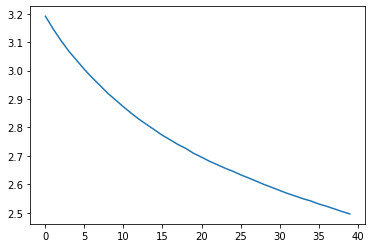

In [81]:
plt.plot(history)
plt.show()

In [92]:
EPOCHS = 40
history = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    history.append(train_loss.result())
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5327 Accuracy 0.4738
Epoch 1 Batch 50 Loss 2.4934 Accuracy 0.4772
Epoch 1 Batch 100 Loss 2.4733 Accuracy 0.4804
Epoch 1 Batch 150 Loss 2.4672 Accuracy 0.4807
Epoch 1 Batch 200 Loss 2.4663 Accuracy 0.4806
Epoch 1 Batch 250 Loss 2.4689 Accuracy 0.4799
Epoch 1 Batch 300 Loss 2.4718 Accuracy 0.4793
Epoch 1 Batch 350 Loss 2.4727 Accuracy 0.4795
Epoch 1 Batch 400 Loss 2.4735 Accuracy 0.4797
Epoch 1 Batch 450 Loss 2.4766 Accuracy 0.4795
Epoch 1 Batch 500 Loss 2.4790 Accuracy 0.4791
Epoch 1 Batch 550 Loss 2.4774 Accuracy 0.4794
Epoch 1 Batch 600 Loss 2.4794 Accuracy 0.4793
Epoch 1 Batch 650 Loss 2.4782 Accuracy 0.4795
Epoch 1 Batch 700 Loss 2.4792 Accuracy 0.4794
Epoch 1 Batch 750 Loss 2.4797 Accuracy 0.4792
Epoch 1 Batch 800 Loss 2.4806 Accuracy 0.4792
Epoch 1 Batch 850 Loss 2.4811 Accuracy 0.4791
Epoch 1 Batch 900 Loss 2.4805 Accuracy 0.4792
Epoch 1 Batch 950 Loss 2.4801 Accuracy 0.4793
Epoch 1 Batch 1000 Loss 2.4804 Accuracy 0.4793
Epoch 1 Batch 1050 Loss 2.4804 Accur

Epoch 4 Batch 600 Loss 2.4545 Accuracy 0.4822
Epoch 4 Batch 650 Loss 2.4551 Accuracy 0.4822
Epoch 4 Batch 700 Loss 2.4568 Accuracy 0.4819
Epoch 4 Batch 750 Loss 2.4561 Accuracy 0.4819
Epoch 4 Batch 800 Loss 2.4565 Accuracy 0.4819
Epoch 4 Batch 850 Loss 2.4569 Accuracy 0.4818
Epoch 4 Batch 900 Loss 2.4569 Accuracy 0.4819
Epoch 4 Batch 950 Loss 2.4568 Accuracy 0.4821
Epoch 4 Batch 1000 Loss 2.4560 Accuracy 0.4822
Epoch 4 Batch 1050 Loss 2.4567 Accuracy 0.4820
Epoch 4 Batch 1100 Loss 2.4564 Accuracy 0.4822
Epoch 4 Batch 1150 Loss 2.4568 Accuracy 0.4822
Epoch 4 Batch 1200 Loss 2.4575 Accuracy 0.4821
Epoch 4 Batch 1250 Loss 2.4578 Accuracy 0.4821
Epoch 4 Batch 1300 Loss 2.4577 Accuracy 0.4822
Epoch 4 Batch 1350 Loss 2.4575 Accuracy 0.4823
Epoch 4 Batch 1400 Loss 2.4576 Accuracy 0.4822
Epoch 4 Batch 1450 Loss 2.4582 Accuracy 0.4821
Epoch 4 Batch 1500 Loss 2.4580 Accuracy 0.4822
Epoch 4 Batch 1550 Loss 2.4589 Accuracy 0.4821
Epoch 4 Batch 1600 Loss 2.4591 Accuracy 0.4821
Epoch 4 Batch 1650 Lo

Epoch 7 Batch 1150 Loss 2.4344 Accuracy 0.4855
Epoch 7 Batch 1200 Loss 2.4340 Accuracy 0.4857
Epoch 7 Batch 1250 Loss 2.4336 Accuracy 0.4858
Epoch 7 Batch 1300 Loss 2.4343 Accuracy 0.4857
Epoch 7 Batch 1350 Loss 2.4339 Accuracy 0.4858
Epoch 7 Batch 1400 Loss 2.4348 Accuracy 0.4856
Epoch 7 Batch 1450 Loss 2.4352 Accuracy 0.4855
Epoch 7 Batch 1500 Loss 2.4352 Accuracy 0.4855
Epoch 7 Batch 1550 Loss 2.4353 Accuracy 0.4854
Epoch 7 Batch 1600 Loss 2.4359 Accuracy 0.4853
Epoch 7 Batch 1650 Loss 2.4354 Accuracy 0.4854
Epoch 7 Batch 1700 Loss 2.4361 Accuracy 0.4854
Epoch 7 Batch 1750 Loss 2.4366 Accuracy 0.4854
Epoch 7 Batch 1800 Loss 2.4363 Accuracy 0.4855
Epoch 7 Batch 1850 Loss 2.4361 Accuracy 0.4855
Epoch 7 Batch 1900 Loss 2.4362 Accuracy 0.4855
Epoch 7 Batch 1950 Loss 2.4362 Accuracy 0.4855
Epoch 7 Batch 2000 Loss 2.4367 Accuracy 0.4855
Epoch 7 Batch 2050 Loss 2.4372 Accuracy 0.4854
Epoch 7 Batch 2100 Loss 2.4376 Accuracy 0.4854
Epoch 7 Batch 2150 Loss 2.4383 Accuracy 0.4853
Epoch 7 Batch

Epoch 10 Batch 1700 Loss 2.4156 Accuracy 0.4882
Epoch 10 Batch 1750 Loss 2.4157 Accuracy 0.4883
Epoch 10 Batch 1800 Loss 2.4158 Accuracy 0.4883
Epoch 10 Batch 1850 Loss 2.4164 Accuracy 0.4883
Epoch 10 Batch 1900 Loss 2.4171 Accuracy 0.4882
Epoch 10 Batch 1950 Loss 2.4172 Accuracy 0.4881
Epoch 10 Batch 2000 Loss 2.4177 Accuracy 0.4880
Epoch 10 Batch 2050 Loss 2.4181 Accuracy 0.4879
Epoch 10 Batch 2100 Loss 2.4184 Accuracy 0.4879
Epoch 10 Batch 2150 Loss 2.4183 Accuracy 0.4880
Epoch 10 Batch 2200 Loss 2.4185 Accuracy 0.4879
Epoch 10 Batch 2250 Loss 2.4187 Accuracy 0.4879
Epoch 10 Batch 2300 Loss 2.4193 Accuracy 0.4878
Epoch 10 Batch 2350 Loss 2.4194 Accuracy 0.4878
Epoch 10 Batch 2400 Loss 2.4197 Accuracy 0.4878
Epoch 10 Batch 2450 Loss 2.4195 Accuracy 0.4878
Epoch 10 Batch 2500 Loss 2.4197 Accuracy 0.4878
Epoch 10 Batch 2550 Loss 2.4204 Accuracy 0.4877
Epoch 10 Batch 2600 Loss 2.4203 Accuracy 0.4877
Saving checkpoint for epoch 10 at ./checkpoints/train_full/ckpt-12
Epoch 10 Loss 2.4205 

Epoch 13 Batch 2050 Loss 2.3984 Accuracy 0.4906
Epoch 13 Batch 2100 Loss 2.3983 Accuracy 0.4906
Epoch 13 Batch 2150 Loss 2.3982 Accuracy 0.4906
Epoch 13 Batch 2200 Loss 2.3985 Accuracy 0.4906
Epoch 13 Batch 2250 Loss 2.3989 Accuracy 0.4905
Epoch 13 Batch 2300 Loss 2.3991 Accuracy 0.4905
Epoch 13 Batch 2350 Loss 2.3992 Accuracy 0.4904
Epoch 13 Batch 2400 Loss 2.3994 Accuracy 0.4904
Epoch 13 Batch 2450 Loss 2.3993 Accuracy 0.4904
Epoch 13 Batch 2500 Loss 2.3997 Accuracy 0.4904
Epoch 13 Batch 2550 Loss 2.3996 Accuracy 0.4904
Epoch 13 Batch 2600 Loss 2.4001 Accuracy 0.4904
Epoch 13 Loss 2.4002 Accuracy 0.4904
Time taken for 1 epoch: 492.9581801891327 secs

Epoch 14 Batch 0 Loss 2.3898 Accuracy 0.4812
Epoch 14 Batch 50 Loss 2.3700 Accuracy 0.4949
Epoch 14 Batch 100 Loss 2.3693 Accuracy 0.4942
Epoch 14 Batch 150 Loss 2.3787 Accuracy 0.4923
Epoch 14 Batch 200 Loss 2.3778 Accuracy 0.4925
Epoch 14 Batch 250 Loss 2.3793 Accuracy 0.4923
Epoch 14 Batch 300 Loss 2.3809 Accuracy 0.4922
Epoch 14 Batc

Epoch 16 Batch 2400 Loss 2.3795 Accuracy 0.4932
Epoch 16 Batch 2450 Loss 2.3799 Accuracy 0.4932
Epoch 16 Batch 2500 Loss 2.3807 Accuracy 0.4931
Epoch 16 Batch 2550 Loss 2.3809 Accuracy 0.4931
Epoch 16 Batch 2600 Loss 2.3813 Accuracy 0.4931
Epoch 16 Loss 2.3814 Accuracy 0.4931
Time taken for 1 epoch: 467.47423243522644 secs

Epoch 17 Batch 0 Loss 2.5285 Accuracy 0.4656
Epoch 17 Batch 50 Loss 2.3558 Accuracy 0.4954
Epoch 17 Batch 100 Loss 2.3418 Accuracy 0.4964
Epoch 17 Batch 150 Loss 2.3489 Accuracy 0.4953
Epoch 17 Batch 200 Loss 2.3492 Accuracy 0.4957
Epoch 17 Batch 250 Loss 2.3498 Accuracy 0.4960
Epoch 17 Batch 300 Loss 2.3513 Accuracy 0.4960
Epoch 17 Batch 350 Loss 2.3523 Accuracy 0.4959
Epoch 17 Batch 400 Loss 2.3552 Accuracy 0.4959
Epoch 17 Batch 450 Loss 2.3578 Accuracy 0.4956
Epoch 17 Batch 500 Loss 2.3588 Accuracy 0.4955
Epoch 17 Batch 550 Loss 2.3611 Accuracy 0.4955
Epoch 17 Batch 600 Loss 2.3629 Accuracy 0.4952
Epoch 17 Batch 650 Loss 2.3613 Accuracy 0.4953
Epoch 17 Batch 700 

Epoch 20 Batch 100 Loss 2.3440 Accuracy 0.4975
Epoch 20 Batch 150 Loss 2.3438 Accuracy 0.4978
Epoch 20 Batch 200 Loss 2.3437 Accuracy 0.4972
Epoch 20 Batch 250 Loss 2.3399 Accuracy 0.4977
Epoch 20 Batch 300 Loss 2.3426 Accuracy 0.4974
Epoch 20 Batch 350 Loss 2.3401 Accuracy 0.4981
Epoch 20 Batch 400 Loss 2.3416 Accuracy 0.4980
Epoch 20 Batch 450 Loss 2.3413 Accuracy 0.4984
Epoch 20 Batch 500 Loss 2.3415 Accuracy 0.4984
Epoch 20 Batch 550 Loss 2.3425 Accuracy 0.4984
Epoch 20 Batch 600 Loss 2.3433 Accuracy 0.4982
Epoch 20 Batch 650 Loss 2.3451 Accuracy 0.4978
Epoch 20 Batch 700 Loss 2.3468 Accuracy 0.4974
Epoch 20 Batch 750 Loss 2.3475 Accuracy 0.4974
Epoch 20 Batch 800 Loss 2.3485 Accuracy 0.4974
Epoch 20 Batch 850 Loss 2.3496 Accuracy 0.4972
Epoch 20 Batch 900 Loss 2.3502 Accuracy 0.4970
Epoch 20 Batch 950 Loss 2.3498 Accuracy 0.4972
Epoch 20 Batch 1000 Loss 2.3495 Accuracy 0.4973
Epoch 20 Batch 1050 Loss 2.3497 Accuracy 0.4973
Epoch 20 Batch 1100 Loss 2.3498 Accuracy 0.4973
Epoch 20 B

Epoch 23 Batch 450 Loss 2.3275 Accuracy 0.5004
Epoch 23 Batch 500 Loss 2.3287 Accuracy 0.5001
Epoch 23 Batch 550 Loss 2.3299 Accuracy 0.5000
Epoch 23 Batch 600 Loss 2.3295 Accuracy 0.5001
Epoch 23 Batch 650 Loss 2.3310 Accuracy 0.5000
Epoch 23 Batch 700 Loss 2.3316 Accuracy 0.4999
Epoch 23 Batch 750 Loss 2.3313 Accuracy 0.4998
Epoch 23 Batch 800 Loss 2.3301 Accuracy 0.5001
Epoch 23 Batch 850 Loss 2.3302 Accuracy 0.5001
Epoch 23 Batch 900 Loss 2.3297 Accuracy 0.5001
Epoch 23 Batch 950 Loss 2.3302 Accuracy 0.5000
Epoch 23 Batch 1000 Loss 2.3304 Accuracy 0.5000
Epoch 23 Batch 1050 Loss 2.3301 Accuracy 0.5000
Epoch 23 Batch 1100 Loss 2.3305 Accuracy 0.5000
Epoch 23 Batch 1150 Loss 2.3308 Accuracy 0.4999
Epoch 23 Batch 1200 Loss 2.3309 Accuracy 0.4999
Epoch 23 Batch 1250 Loss 2.3308 Accuracy 0.4998
Epoch 23 Batch 1300 Loss 2.3317 Accuracy 0.4998
Epoch 23 Batch 1350 Loss 2.3330 Accuracy 0.4996
Epoch 23 Batch 1400 Loss 2.3333 Accuracy 0.4996
Epoch 23 Batch 1450 Loss 2.3336 Accuracy 0.4997
Epo

Epoch 26 Batch 800 Loss 2.3098 Accuracy 0.5031
Epoch 26 Batch 850 Loss 2.3099 Accuracy 0.5030
Epoch 26 Batch 900 Loss 2.3095 Accuracy 0.5032
Epoch 26 Batch 950 Loss 2.3094 Accuracy 0.5030
Epoch 26 Batch 1000 Loss 2.3108 Accuracy 0.5028
Epoch 26 Batch 1050 Loss 2.3111 Accuracy 0.5028
Epoch 26 Batch 1100 Loss 2.3111 Accuracy 0.5028
Epoch 26 Batch 1150 Loss 2.3114 Accuracy 0.5027
Epoch 26 Batch 1200 Loss 2.3118 Accuracy 0.5026
Epoch 26 Batch 1250 Loss 2.3116 Accuracy 0.5027
Epoch 26 Batch 1300 Loss 2.3126 Accuracy 0.5025
Epoch 26 Batch 1350 Loss 2.3127 Accuracy 0.5025
Epoch 26 Batch 1400 Loss 2.3130 Accuracy 0.5025
Epoch 26 Batch 1450 Loss 2.3135 Accuracy 0.5024
Epoch 26 Batch 1500 Loss 2.3136 Accuracy 0.5025
Epoch 26 Batch 1550 Loss 2.3139 Accuracy 0.5025
Epoch 26 Batch 1600 Loss 2.3137 Accuracy 0.5025
Epoch 26 Batch 1650 Loss 2.3142 Accuracy 0.5025
Epoch 26 Batch 1700 Loss 2.3144 Accuracy 0.5025
Epoch 26 Batch 1750 Loss 2.3148 Accuracy 0.5025
Epoch 26 Batch 1800 Loss 2.3150 Accuracy 0.5

Epoch 29 Batch 1200 Loss 2.2959 Accuracy 0.5051
Epoch 29 Batch 1250 Loss 2.2956 Accuracy 0.5052
Epoch 29 Batch 1300 Loss 2.2960 Accuracy 0.5051
Epoch 29 Batch 1350 Loss 2.2970 Accuracy 0.5050
Epoch 29 Batch 1400 Loss 2.2977 Accuracy 0.5049
Epoch 29 Batch 1450 Loss 2.2982 Accuracy 0.5049
Epoch 29 Batch 1500 Loss 2.2990 Accuracy 0.5048
Epoch 29 Batch 1550 Loss 2.2993 Accuracy 0.5048
Epoch 29 Batch 1600 Loss 2.2989 Accuracy 0.5049
Epoch 29 Batch 1650 Loss 2.2995 Accuracy 0.5049
Epoch 29 Batch 1700 Loss 2.3000 Accuracy 0.5047
Epoch 29 Batch 1750 Loss 2.2999 Accuracy 0.5047
Epoch 29 Batch 1800 Loss 2.3002 Accuracy 0.5046
Epoch 29 Batch 1850 Loss 2.3004 Accuracy 0.5045
Epoch 29 Batch 1900 Loss 2.3007 Accuracy 0.5045
Epoch 29 Batch 1950 Loss 2.3009 Accuracy 0.5045
Epoch 29 Batch 2000 Loss 2.3012 Accuracy 0.5045
Epoch 29 Batch 2050 Loss 2.3015 Accuracy 0.5044
Epoch 29 Batch 2100 Loss 2.3013 Accuracy 0.5045
Epoch 29 Batch 2150 Loss 2.3015 Accuracy 0.5044
Epoch 29 Batch 2200 Loss 2.3016 Accuracy

Epoch 32 Batch 1550 Loss 2.2807 Accuracy 0.5073
Epoch 32 Batch 1600 Loss 2.2812 Accuracy 0.5072
Epoch 32 Batch 1650 Loss 2.2817 Accuracy 0.5072
Epoch 32 Batch 1700 Loss 2.2823 Accuracy 0.5071
Epoch 32 Batch 1750 Loss 2.2826 Accuracy 0.5071
Epoch 32 Batch 1800 Loss 2.2833 Accuracy 0.5070
Epoch 32 Batch 1850 Loss 2.2832 Accuracy 0.5071
Epoch 32 Batch 1900 Loss 2.2839 Accuracy 0.5070
Epoch 32 Batch 1950 Loss 2.2842 Accuracy 0.5069
Epoch 32 Batch 2000 Loss 2.2840 Accuracy 0.5069
Epoch 32 Batch 2050 Loss 2.2843 Accuracy 0.5069
Epoch 32 Batch 2100 Loss 2.2846 Accuracy 0.5068
Epoch 32 Batch 2150 Loss 2.2849 Accuracy 0.5067
Epoch 32 Batch 2200 Loss 2.2853 Accuracy 0.5066
Epoch 32 Batch 2250 Loss 2.2856 Accuracy 0.5065
Epoch 32 Batch 2300 Loss 2.2860 Accuracy 0.5065
Epoch 32 Batch 2350 Loss 2.2861 Accuracy 0.5065
Epoch 32 Batch 2400 Loss 2.2861 Accuracy 0.5065
Epoch 32 Batch 2450 Loss 2.2866 Accuracy 0.5065
Epoch 32 Batch 2500 Loss 2.2867 Accuracy 0.5064
Epoch 32 Batch 2550 Loss 2.2873 Accuracy

Epoch 35 Batch 1950 Loss 2.2672 Accuracy 0.5090
Epoch 35 Batch 2000 Loss 2.2672 Accuracy 0.5090
Epoch 35 Batch 2050 Loss 2.2670 Accuracy 0.5090
Epoch 35 Batch 2100 Loss 2.2677 Accuracy 0.5089
Epoch 35 Batch 2150 Loss 2.2680 Accuracy 0.5089
Epoch 35 Batch 2200 Loss 2.2687 Accuracy 0.5087
Epoch 35 Batch 2250 Loss 2.2689 Accuracy 0.5087
Epoch 35 Batch 2300 Loss 2.2688 Accuracy 0.5087
Epoch 35 Batch 2350 Loss 2.2688 Accuracy 0.5087
Epoch 35 Batch 2400 Loss 2.2691 Accuracy 0.5087
Epoch 35 Batch 2450 Loss 2.2692 Accuracy 0.5087
Epoch 35 Batch 2500 Loss 2.2696 Accuracy 0.5087
Epoch 35 Batch 2550 Loss 2.2702 Accuracy 0.5086
Epoch 35 Batch 2600 Loss 2.2707 Accuracy 0.5085
Saving checkpoint for epoch 35 at ./checkpoints/train_full/ckpt-17
Epoch 35 Loss 2.2710 Accuracy 0.5085
Time taken for 1 epoch: 455.84616136550903 secs

Epoch 36 Batch 0 Loss 2.0926 Accuracy 0.5395
Epoch 36 Batch 50 Loss 2.2341 Accuracy 0.5113
Epoch 36 Batch 100 Loss 2.2360 Accuracy 0.5110
Epoch 36 Batch 150 Loss 2.2367 Accura

Epoch 38 Batch 2300 Loss 2.2531 Accuracy 0.5111
Epoch 38 Batch 2350 Loss 2.2530 Accuracy 0.5111
Epoch 38 Batch 2400 Loss 2.2536 Accuracy 0.5110
Epoch 38 Batch 2450 Loss 2.2541 Accuracy 0.5110
Epoch 38 Batch 2500 Loss 2.2545 Accuracy 0.5109
Epoch 38 Batch 2550 Loss 2.2547 Accuracy 0.5109
Epoch 38 Batch 2600 Loss 2.2551 Accuracy 0.5109
Epoch 38 Loss 2.2553 Accuracy 0.5108
Time taken for 1 epoch: 455.543404340744 secs

Epoch 39 Batch 0 Loss 2.3539 Accuracy 0.5013
Epoch 39 Batch 50 Loss 2.2489 Accuracy 0.5133
Epoch 39 Batch 100 Loss 2.2379 Accuracy 0.5136
Epoch 39 Batch 150 Loss 2.2338 Accuracy 0.5135
Epoch 39 Batch 200 Loss 2.2309 Accuracy 0.5139
Epoch 39 Batch 250 Loss 2.2304 Accuracy 0.5138
Epoch 39 Batch 300 Loss 2.2302 Accuracy 0.5142
Epoch 39 Batch 350 Loss 2.2324 Accuracy 0.5138
Epoch 39 Batch 400 Loss 2.2349 Accuracy 0.5136
Epoch 39 Batch 450 Loss 2.2360 Accuracy 0.5135
Epoch 39 Batch 500 Loss 2.2381 Accuracy 0.5130
Epoch 39 Batch 550 Loss 2.2386 Accuracy 0.5131
Epoch 39 Batch 600 

In [93]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    history.append(train_loss.result())
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2032 Accuracy 0.5107
Epoch 1 Batch 50 Loss 2.2361 Accuracy 0.5128
Epoch 1 Batch 100 Loss 2.2264 Accuracy 0.5137
Epoch 1 Batch 150 Loss 2.2211 Accuracy 0.5141
Epoch 1 Batch 200 Loss 2.2285 Accuracy 0.5130
Epoch 1 Batch 250 Loss 2.2293 Accuracy 0.5134
Epoch 1 Batch 300 Loss 2.2282 Accuracy 0.5136
Epoch 1 Batch 350 Loss 2.2289 Accuracy 0.5137
Epoch 1 Batch 400 Loss 2.2280 Accuracy 0.5140
Epoch 1 Batch 450 Loss 2.2276 Accuracy 0.5141
Epoch 1 Batch 500 Loss 2.2285 Accuracy 0.5139
Epoch 1 Batch 550 Loss 2.2287 Accuracy 0.5138
Epoch 1 Batch 600 Loss 2.2292 Accuracy 0.5140
Epoch 1 Batch 650 Loss 2.2297 Accuracy 0.5141
Epoch 1 Batch 700 Loss 2.2315 Accuracy 0.5137
Epoch 1 Batch 750 Loss 2.2322 Accuracy 0.5135
Epoch 1 Batch 800 Loss 2.2313 Accuracy 0.5137
Epoch 1 Batch 850 Loss 2.2331 Accuracy 0.5135
Epoch 1 Batch 900 Loss 2.2332 Accuracy 0.5135
Epoch 1 Batch 950 Loss 2.2334 Accuracy 0.5135
Epoch 1 Batch 1000 Loss 2.2335 Accuracy 0.5136
Epoch 1 Batch 1050 Loss 2.2337 Accur

Epoch 4 Batch 600 Loss 2.2146 Accuracy 0.5165
Epoch 4 Batch 650 Loss 2.2168 Accuracy 0.5161
Epoch 4 Batch 700 Loss 2.2165 Accuracy 0.5160
Epoch 4 Batch 750 Loss 2.2176 Accuracy 0.5160
Epoch 4 Batch 800 Loss 2.2185 Accuracy 0.5158
Epoch 4 Batch 850 Loss 2.2185 Accuracy 0.5158
Epoch 4 Batch 900 Loss 2.2184 Accuracy 0.5159
Epoch 4 Batch 950 Loss 2.2183 Accuracy 0.5158
Epoch 4 Batch 1000 Loss 2.2189 Accuracy 0.5158
Epoch 4 Batch 1050 Loss 2.2190 Accuracy 0.5159
Epoch 4 Batch 1100 Loss 2.2194 Accuracy 0.5157
Epoch 4 Batch 1150 Loss 2.2191 Accuracy 0.5158
Epoch 4 Batch 1200 Loss 2.2194 Accuracy 0.5158
Epoch 4 Batch 1250 Loss 2.2192 Accuracy 0.5159
Epoch 4 Batch 1300 Loss 2.2193 Accuracy 0.5158
Epoch 4 Batch 1350 Loss 2.2196 Accuracy 0.5158
Epoch 4 Batch 1400 Loss 2.2201 Accuracy 0.5157
Epoch 4 Batch 1450 Loss 2.2207 Accuracy 0.5157
Epoch 4 Batch 1500 Loss 2.2210 Accuracy 0.5157
Epoch 4 Batch 1550 Loss 2.2214 Accuracy 0.5157
Epoch 4 Batch 1600 Loss 2.2214 Accuracy 0.5157
Epoch 4 Batch 1650 Lo

Epoch 7 Batch 1150 Loss 2.2050 Accuracy 0.5181
Epoch 7 Batch 1200 Loss 2.2053 Accuracy 0.5180
Epoch 7 Batch 1250 Loss 2.2053 Accuracy 0.5180
Epoch 7 Batch 1300 Loss 2.2051 Accuracy 0.5180
Epoch 7 Batch 1350 Loss 2.2046 Accuracy 0.5181
Epoch 7 Batch 1400 Loss 2.2052 Accuracy 0.5181
Epoch 7 Batch 1450 Loss 2.2061 Accuracy 0.5179
Epoch 7 Batch 1500 Loss 2.2072 Accuracy 0.5177
Epoch 7 Batch 1550 Loss 2.2070 Accuracy 0.5178
Epoch 7 Batch 1600 Loss 2.2071 Accuracy 0.5178
Epoch 7 Batch 1650 Loss 2.2071 Accuracy 0.5178
Epoch 7 Batch 1700 Loss 2.2074 Accuracy 0.5178
Epoch 7 Batch 1750 Loss 2.2078 Accuracy 0.5177
Epoch 7 Batch 1800 Loss 2.2079 Accuracy 0.5178
Epoch 7 Batch 1850 Loss 2.2081 Accuracy 0.5178
Epoch 7 Batch 1900 Loss 2.2086 Accuracy 0.5176
Epoch 7 Batch 1950 Loss 2.2088 Accuracy 0.5176
Epoch 7 Batch 2000 Loss 2.2091 Accuracy 0.5176
Epoch 7 Batch 2050 Loss 2.2094 Accuracy 0.5175
Epoch 7 Batch 2100 Loss 2.2096 Accuracy 0.5175
Epoch 7 Batch 2150 Loss 2.2101 Accuracy 0.5174
Epoch 7 Batch

Epoch 10 Batch 1700 Loss 2.1962 Accuracy 0.5193
Epoch 10 Batch 1750 Loss 2.1966 Accuracy 0.5193
Epoch 10 Batch 1800 Loss 2.1969 Accuracy 0.5192
Epoch 10 Batch 1850 Loss 2.1972 Accuracy 0.5192
Epoch 10 Batch 1900 Loss 2.1976 Accuracy 0.5191
Epoch 10 Batch 1950 Loss 2.1980 Accuracy 0.5191
Epoch 10 Batch 2000 Loss 2.1980 Accuracy 0.5190
Epoch 10 Batch 2050 Loss 2.1980 Accuracy 0.5190
Epoch 10 Batch 2100 Loss 2.1986 Accuracy 0.5189
Epoch 10 Batch 2150 Loss 2.1988 Accuracy 0.5189
Epoch 10 Batch 2200 Loss 2.1986 Accuracy 0.5190
Epoch 10 Batch 2250 Loss 2.1988 Accuracy 0.5189
Epoch 10 Batch 2300 Loss 2.1987 Accuracy 0.5190
Epoch 10 Batch 2350 Loss 2.1984 Accuracy 0.5191
Epoch 10 Batch 2400 Loss 2.1989 Accuracy 0.5190
Epoch 10 Batch 2450 Loss 2.1995 Accuracy 0.5188
Epoch 10 Batch 2500 Loss 2.2000 Accuracy 0.5188
Epoch 10 Batch 2550 Loss 2.2004 Accuracy 0.5187
Epoch 10 Batch 2600 Loss 2.2006 Accuracy 0.5187
Saving checkpoint for epoch 10 at ./checkpoints/train_full/ckpt-20
Epoch 10 Loss 2.2010 

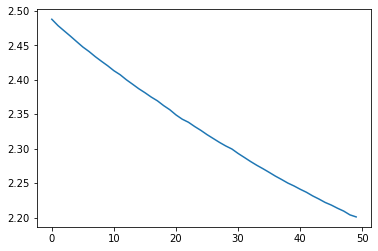

In [94]:
plt.plot(history)
plt.show()

In [95]:
# Так заманчиво падает но очень медленно на самом деле... Окей. 100 эпох думаю хватит пока )

In [96]:
# Инференс - тут как в генерации текста. Отличия в том, что мы вычисляем метки начала и конца для разных языков
# И маски, padding и look-ahead 

In [97]:
def evaluate(inp_sentence):
    start_token = [tokenizer_ru.vocab_size]
    end_token = [tokenizer_ru.vocab_size + 1]

    # inp sentence is russian, hence adding the start and end token
    inp_sentence = start_token + tokenizer_ru.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [98]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [99]:
translate('Осенним вечером шёл дождь!')

Input: Осенним вечером шёл дождь!
Predicted translation: winter night .


In [86]:
# Началось веселье! )

In [106]:
translate('Я должен идти домой')

Input: Я должен идти домой
Predicted translation: you have to stay home .


In [107]:
translate('Мама мыла раму')

Input: Мама мыла раму
Predicted translation: it 's a natural free-living organism .


In [108]:
translate('Это невозможно')

Input: Это невозможно
Predicted translation: it does n't have to be any other way to evolve .


In [109]:
translate('С причала рыбачил апостол Андрей')

Input: С причала рыбачил апостол Андрей
Predicted translation: it was a freak of candles , and it was a death sentence .


In [ ]:
# Если принять во внимание текст песни то кажется упоминание "смертного приговора" в переводе не так уж и абсурдно

In [110]:
translate('Очень скоро здесь станет совсем темно')

Input: Очень скоро здесь станет совсем темно
Predicted translation: the reality is almost a little bit long in the dark .


In [111]:
translate('с оружием в руках')

Input: с оружием в руках
Predicted translation: it was a death penalty .


In [112]:
translate('перемены возможны только с оружием в руках')

Input: перемены возможны только с оружием в руках
Predicted translation: we can do that with a lot of other people .


In [113]:
# Даже примеры из собственного трейн датасета он перевести не может никак (
# Seq2seq c вниманием был как-то более вменяем